In [26]:
%store -r X_train_encoded
%store -r X_test_encoded
%store -r y_train
%store -r y_test
%store -r column_names
%store -r preds_linear
%store -r preds_lasso
%store -r preds_ridge
from joblib import load
models=load('all_models_filename.joblib')
lasso_cv=models['model1']
ridge_cv=models['model2']

# Modeling

The objective of this project is to build models to predict the price of car as a function of features that define a car and and to study how the variation of the different features affect the price of the car

The purpose of this notebook is to use additional algorithms to model the relationship between features and car price then comparison their performance.

Table of Contents

[e.1 Random Forests/XGBoosting/LightGBM](#e.1)

[e.2 Residual Histogram](#e.2)

[e.3 MAPE PLOT](#e.3)

[e.4 SHAP](#e.4)

[e.5 SUMMARY](#e.5)


In [27]:
# Import necessary libraries
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

<a id="e.1"></a>
## e.1 Random Forests/XGBoosting/LightGBM

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import numpy as np
import xgboost as xgb
import lightgbm as lgb

# Function to calculate Adjusted R-squared
def adjusted_r2_score(r2, n, p):
    if n == p:
        return float('inf')
    else:
        return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = (y_true != 0)
    y_true = y_true[non_zero_index]
    y_pred = y_pred[non_zero_index]
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to perform grid search with pipeline and calculate metrics
def perform_grid_search_and_evaluate(model, param_grid, X_train, y_train, X_test, y_test):
    # Create a pipeline with data pre-processing and model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    # Create GridSearchCV
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, 
                               cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)

    # Best parameters and best model
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    print(f"Best Parameters for {type(model).__name__}: {best_params}")

    # Make predictions using the best model
    preds = best_model.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    adj_r2 = adjusted_r2_score(r2, y_test.shape[0], X_test.shape[1])
    mape = mean_absolute_percentage_error(y_test, preds)

    print(f"RMSE for {type(model).__name__}: {rmse}")
    print(f"Adjusted R-squared for {type(model).__name__}: {adj_r2}")
    print(f"MAPE for {type(model).__name__}: {mape}%")

    return best_model, preds, rmse, adj_r2, mape

# Define your parameter grids here
rf_param_grid = {
    'model__n_estimators': [98, 100, 102, 110],
    'model__max_depth': [None, 9, 10, 11, 30]
}

xgb_param_grid = {
    'model__colsample_bytree': [0.4, 0.3, 0.5],
    'model__learning_rate': [0.2, 0.1, 0.3],
    'model__max_depth': [5, 3, 4],
    'model__alpha': [5, 4, 6],
    'model__n_estimators': [120, 115, 117]
}

lgb_param_grid = {
    'model__learning_rate': [0.05, 0.1, 0.2],
    'model__n_estimators': [50, 100, 200],
    'model__num_leaves': [31, 50, 100],
    'model__max_depth': [5, 10, 20]
}

# Perform grid search and evaluate for each model using the defined parameter grids
# Assuming you have already defined the function perform_grid_search_and_evaluate
# and you have the X_train_encoded, y_train, X_test_encoded, y_test datasets ready

rf_model, rf_preds, rf_rmse, rf_adj_r2, rf_mape = perform_grid_search_and_evaluate(
    RandomForestRegressor(random_state=42), rf_param_grid, X_train_encoded, y_train, X_test_encoded, y_test)

xgb_model, xgb_preds, xgb_rmse, xgb_adj_r2, xgb_mape = perform_grid_search_and_evaluate(
    xgb.XGBRegressor(objective='reg:squarederror'), xgb_param_grid, X_train_encoded, y_train, X_test_encoded, y_test)

lgb_model, lgb_preds, lgb_rmse, lgb_adj_r2, lgb_mape = perform_grid_search_and_evaluate(
    lgb.LGBMRegressor(objective='regression'), lgb_param_grid, X_train_encoded, y_train, X_test_encoded, y_test)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters for RandomForestRegressor: {'model__max_depth': 10, 'model__n_estimators': 98}
RMSE for RandomForestRegressor: 2087.360957744833
Adjusted R-squared for RandomForestRegressor: 1.2189500297182945
MAPE for RandomForestRegressor: 10.789883507310366%
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters for XGBRegressor: {'model__alpha': 5, 'model__colsample_bytree': 0.4, 'model__learning_rate': 0.2, 'model__max_depth': 3, 'model__n_estimators': 120}
RMSE for XGBRegressor: 2110.522302558897
Adjusted R-squared for XGBRegressor: 1.2238359235472
MAPE for XGBRegressor: 11.190693350616678%
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters for LGBMRegressor: {'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__n_estimators': 100, 'model__num_leaves': 31}
RMSE for LGBMRegressor: 3215.872104062192
Adjusted R-squared for LGBMRegressor: 1.5196936772792382
MAPE for 

<a id="e.2"></a>
## e.2 Residual Histogram

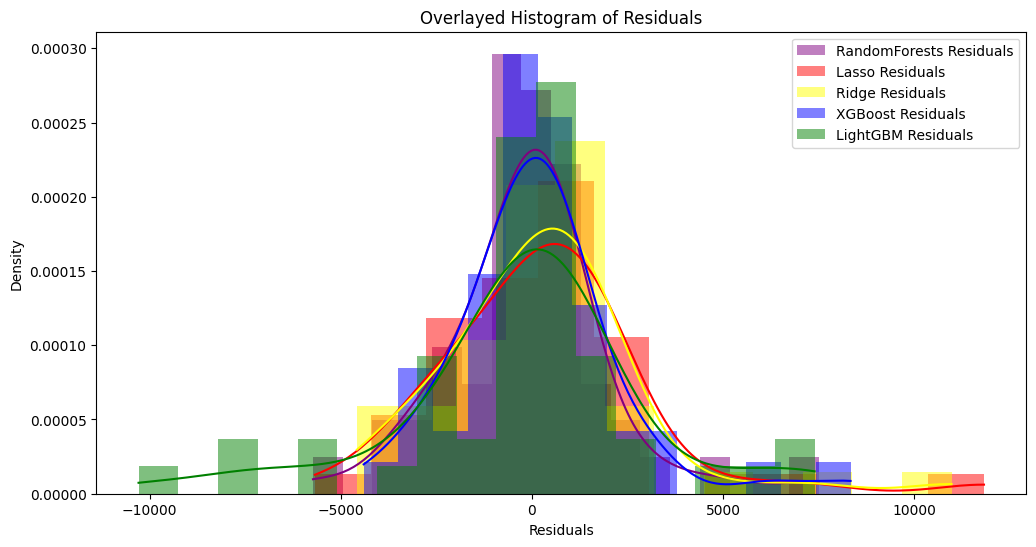

In [37]:
import seaborn as sns

# Calculate residuals
#residuals_randomforests = y_test - random_forest_model.predict(X_test_scaled)
# residuals_lasso = y_test - lasso_cv.predict(X_test_scaled)
# residuals_ridge = y_test - ridge_cv.predict(X_test_scaled)
# residuals_xgb = y_test - xg_reg.predict(X_test_scaled)  # from XGBoost
# residuals_lgbm = y_test - lgb_reg.predict(X_test_scaled)  # from LightGBM

residuals_randomforests = y_test - rf_preds
residuals_lasso = y_test - preds_lasso
residuals_ridge = y_test - preds_ridge
residuals_xgb = y_test - xgb_preds
residuals_lgbm = y_test - lgb_preds


# Set up the matplotlib figure
plt.figure(figsize=(12, 6))

# Plot histogram of residuals for each model
sns.histplot(residuals_randomforests, color="purple", label="RandomForests Residuals", kde=True, stat="density", linewidth=0)
sns.histplot(residuals_lasso, color="red", label="Lasso Residuals", kde=True, stat="density", linewidth=0)
sns.histplot(residuals_ridge, color="yellow", label="Ridge Residuals", kde=True, stat="density", linewidth=0)
sns.histplot(residuals_xgb, color="blue", label="XGBoost Residuals", kde=True, stat="density", linewidth=0)
sns.histplot(residuals_lgbm, color="green", label="LightGBM Residuals", kde=True, stat="density", linewidth=0)

# Plot formatting
plt.title('Overlayed Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.legend()

plt.show()

The RandomForests model histogram shows the smallest spread of residuals and tallest peak. It also centers around zero. The XGBoost model histgram shows the wider spread of residuals and it does not center around zero. The Lassso and Ridge models show similar performance. Therefore, Randomforests model is the best choice. 

<a id="e.3"></a>
## e.3 MAPE PLOT

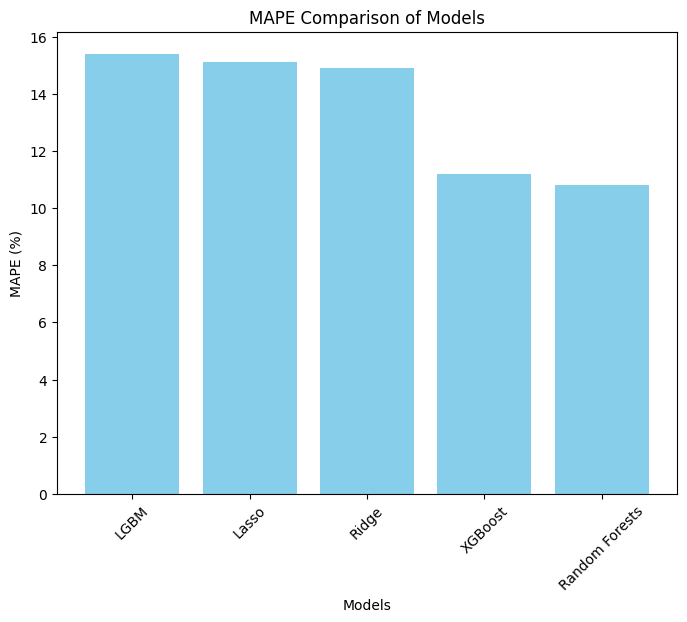

[CV] END .....model__max_depth=None, model__n_estimators=100; total time=   0.1s
[CV] END ........model__max_depth=9, model__n_estimators=100; total time=   0.1s
[CV] END ........model__max_depth=9, model__n_estimators=110; total time=   0.1s
[CV] END .......model__max_depth=10, model__n_estimators=100; total time=   0.1s
[CV] END .......model__max_depth=10, model__n_estimators=110; total time=   0.1s
[CV] END .......model__max_depth=11, model__n_estimators=102; total time=   0.1s
[CV] END ........model__max_depth=30, model__n_estimators=98; total time=   0.1s
[CV] END .......model__max_depth=30, model__n_estimators=110; total time=   0.1s
[CV] END ......model__max_depth=None, model__n_estimators=98; total time=   0.2s
[CV] END .....model__max_depth=None, model__n_estimators=110; total time=   0.2s
[CV] END ........model__max_depth=10, model__n_estimators=98; total time=   0.2s
[CV] END ........model__max_depth=10, model__n_estimators=98; total time=   0.1s
[CV] END ........model__max_

[CV] END .....model__max_depth=None, model__n_estimators=102; total time=   0.1s
[CV] END .....model__max_depth=None, model__n_estimators=110; total time=   0.1s
[CV] END ........model__max_depth=9, model__n_estimators=110; total time=   0.1s
[CV] END .......model__max_depth=10, model__n_estimators=100; total time=   0.1s
[CV] END .......model__max_depth=11, model__n_estimators=100; total time=   0.1s
[CV] END .......model__max_depth=11, model__n_estimators=110; total time=   0.1s
[CV] END .......model__max_depth=30, model__n_estimators=102; total time=   0.1s
[CV] END ......model__max_depth=None, model__n_estimators=98; total time=   0.2s
[CV] END .....model__max_depth=None, model__n_estimators=110; total time=   0.1s
[CV] END ........model__max_depth=9, model__n_estimators=102; total time=   0.1s
[CV] END ........model__max_depth=9, model__n_estimators=102; total time=   0.1s
[CV] END .......model__max_depth=10, model__n_estimators=102; total time=   0.1s
[CV] END .......model__max_d

[CV] END model__alpha=5, model__colsample_bytree=0.4, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=120; total time=   0.0s
[CV] END model__alpha=5, model__colsample_bytree=0.4, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=115; total time=   0.0s
[CV] END model__alpha=5, model__colsample_bytree=0.4, model__learning_rate=0.3, model__max_depth=4, model__n_estimators=115; total time=   0.0s
[CV] END model__alpha=5, model__colsample_bytree=0.4, model__learning_rate=0.3, model__max_depth=4, model__n_estimators=115; total time=   0.0s
[CV] END model__alpha=5, model__colsample_bytree=0.4, model__learning_rate=0.3, model__max_depth=4, model__n_estimators=117; total time=   0.0s
[CV] END model__alpha=5, model__colsample_bytree=0.4, model__learning_rate=0.3, model__max_depth=4, model__n_estimators=117; total time=   0.0s
[CV] END model__alpha=5, model__colsample_bytree=0.3, model__learning_rate=0.2, model__max_depth=4, model__n_estimators=120; total time=

[CV] END .....model__max_depth=None, model__n_estimators=100; total time=   0.1s
[CV] END .........model__max_depth=9, model__n_estimators=98; total time=   0.1s
[CV] END ........model__max_depth=9, model__n_estimators=100; total time=   0.1s
[CV] END ........model__max_depth=10, model__n_estimators=98; total time=   0.1s
[CV] END .......model__max_depth=10, model__n_estimators=110; total time=   0.1s
[CV] END .......model__max_depth=11, model__n_estimators=100; total time=   0.1s
[CV] END ........model__max_depth=30, model__n_estimators=98; total time=   0.1s
[CV] END .......model__max_depth=30, model__n_estimators=110; total time=   0.1s
[CV] END .....model__max_depth=None, model__n_estimators=102; total time=   0.2s
[CV] END .........model__max_depth=9, model__n_estimators=98; total time=   0.1s
[CV] END .......model__max_depth=10, model__n_estimators=100; total time=   0.2s
[CV] END .......model__max_depth=10, model__n_estimators=100; total time=   0.1s
[CV] END .......model__max_d

[CV] END ......model__max_depth=None, model__n_estimators=98; total time=   0.1s
[CV] END .....model__max_depth=None, model__n_estimators=110; total time=   0.1s
[CV] END ........model__max_depth=9, model__n_estimators=102; total time=   0.1s
[CV] END .......model__max_depth=10, model__n_estimators=102; total time=   0.1s
[CV] END ........model__max_depth=11, model__n_estimators=98; total time=   0.1s
[CV] END .......model__max_depth=11, model__n_estimators=102; total time=   0.1s
[CV] END .......model__max_depth=30, model__n_estimators=100; total time=   0.1s
[CV] END .....model__max_depth=None, model__n_estimators=100; total time=   0.2s
[CV] END .........model__max_depth=9, model__n_estimators=98; total time=   0.1s
[CV] END ........model__max_depth=10, model__n_estimators=98; total time=   0.2s
[CV] END .......model__max_depth=10, model__n_estimators=100; total time=   0.1s
[CV] END .......model__max_depth=11, model__n_estimators=100; total time=   0.1s
[CV] END .......model__max_d

In [38]:
import matplotlib.pyplot as plt

# Example MAPE values for two models (replace these with your actual MAPE values)
mape_values = {
    "Lasso": 15.1, 
    "Ridge":14.9,
    "Random Forests":10.8,
    "XGBoost":11.2,
    "LGBM":15.4
    # Add any additional models here
}

# Sorting the MAPE values in descending order
sorted_mape_values = dict(sorted(mape_values.items(), key=lambda item: item[1], reverse=True))

# Creating a bar chart
plt.figure(figsize=(8, 6))
plt.bar(sorted_mape_values.keys(), sorted_mape_values.values(), color='skyblue')
plt.xlabel('Models')
plt.ylabel('MAPE (%)')
plt.title('MAPE Comparison of Models')
plt.xticks(rotation=45)
plt.show()


Since Random Forests model has the smallest MAPE, adjusted r-squared closest to 1, and smallest RMSE, it is selected as the best model.

<a id="e.4"></a>
## e.4 SHAP

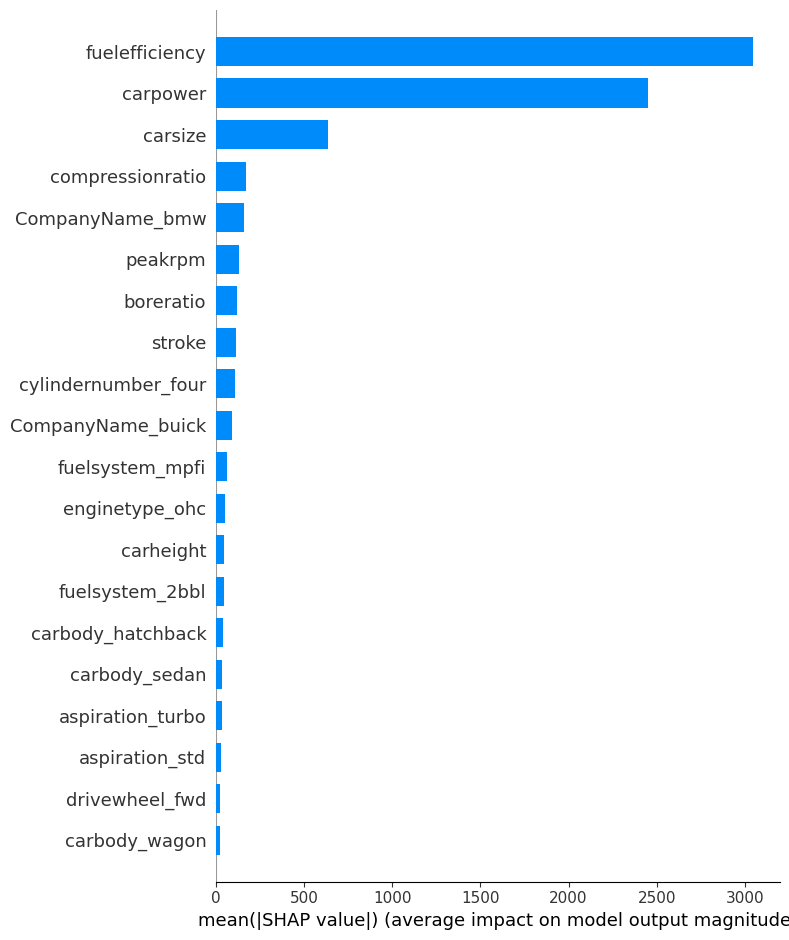

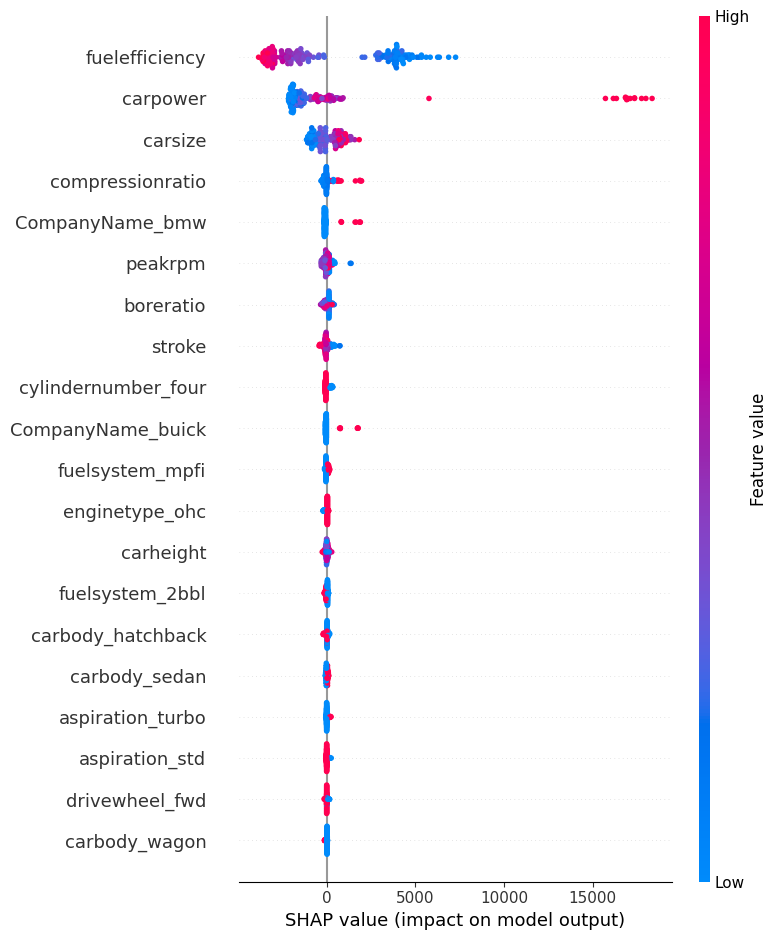

In [40]:
#SHAP

import shap

%matplotlib inline

# Concatenate X_train_encoded and X_test_encoded along rows
X_combined = np.concatenate([X_train_encoded, X_test_encoded], axis=0)

# Concatenate y_train and y_test similarly if they are numpy arrays
y_combined = np.concatenate([y_train, y_test], axis=0)

best_model = RandomForestRegressor(**random_forest_params, random_state=42)
best_model.fit(X_combined, y_combined)  # Retrain on the entire dataset
# Convert X_test_scaled to DataFrame with correct column names
# X_test_scaled = pd.DataFrame(X_combined, columns=column_names)
X_scaled = pd.DataFrame(X_combined, columns=column_names)


# Initialize SHAP explainer
explainer = shap.Explainer(random_forest_best_model, X_scaled)


# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_scaled)


# Visualize the SHAP summary plot
shap.summary_plot(shap_values, X_scaled
                  , plot_type="bar")


# Visualize detailed SHAP summary plot
shap.summary_plot(shap_values, X_scaled)


From the SHAP summary plot, fuelefficiency, carpower, and carsize are the top three features that impact car price. In the low range fuelefficiency, higher fuelefficiency increases the predicted car price. In the high range fuelefficiency, higher fuelefficiency decreases the predicted car price.  

For feature carpower, some high carpower values has very strong impact on increasing car price. The rest of carpower values show modest impact on car price.

For feature carsize, high carsize values has impact on increasing car price while low carsize values has impact on decreasing car price. 

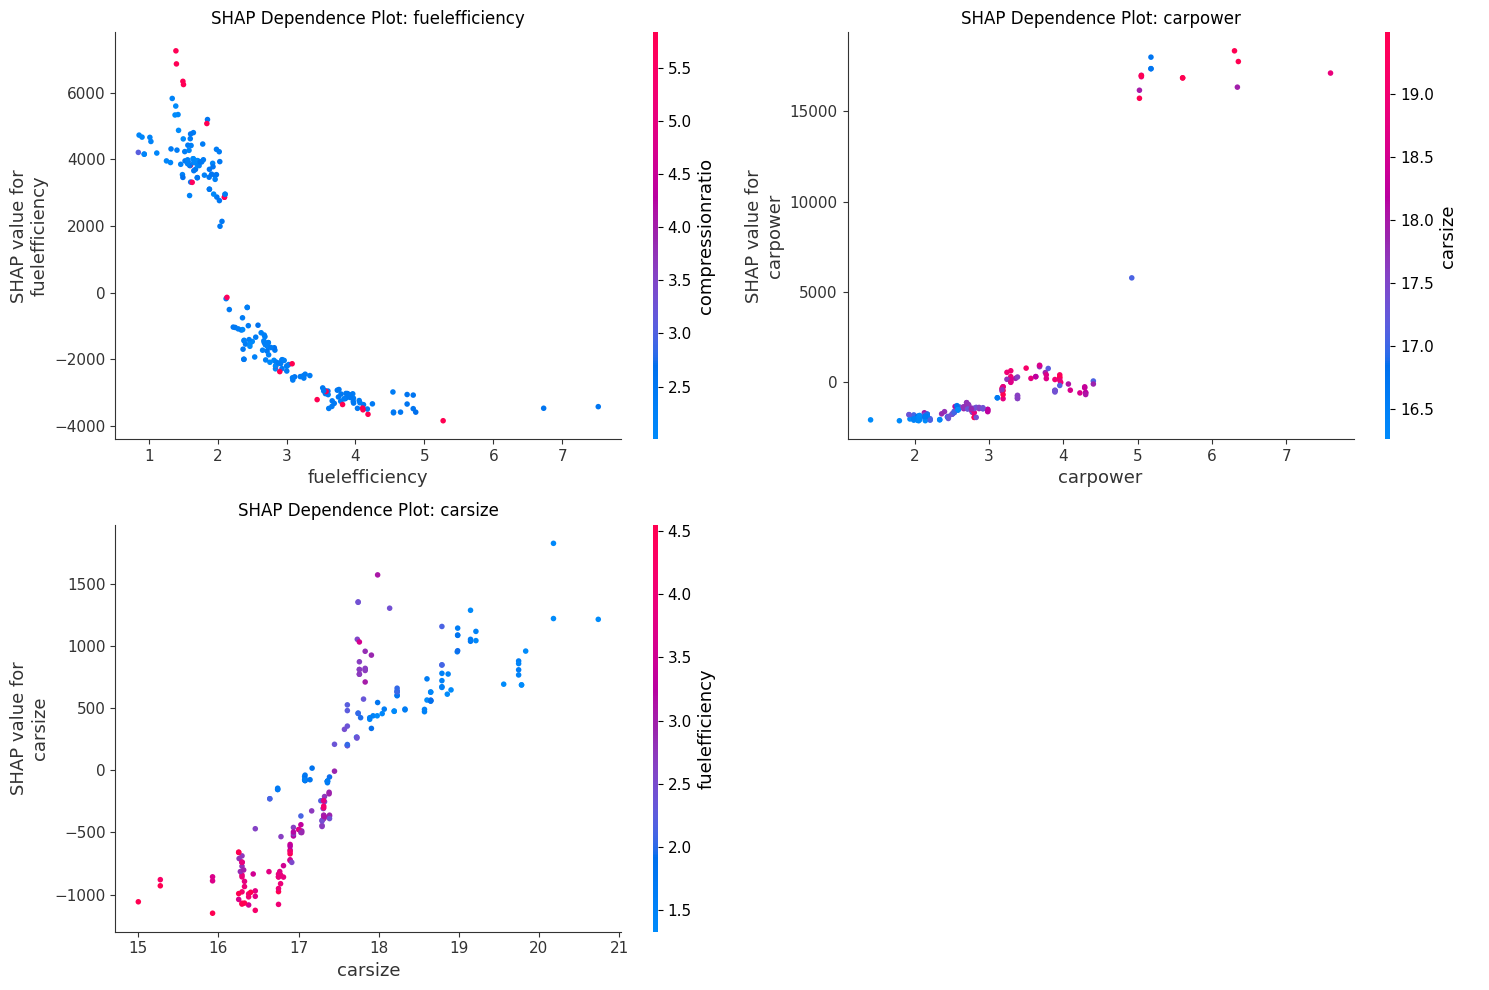

In [41]:

# Initialize SHAP explainer
explainer = shap.Explainer(random_forest_best_model, X_scaled)

# Convert the numpy array back to pandas DataFrame
X_test_scaled_df = pd.DataFrame(X_scaled, columns=column_names)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_scaled)

# Define the features of interest
features_of_interest = ['fuelefficiency', 'carpower', 'carsize']

# Set up a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()  # Flatten to 1D array for easy iteration

# Plot SHAP dependence plots for each feature
for i, feature in enumerate(features_of_interest):
    shap.dependence_plot(feature, shap_values, X_scaled, ax=axs[i], show=False)
    axs[i].set_title(f'SHAP Dependence Plot: {feature}')

# Hide the last subplot (empty)
axs[-1].axis('off')

plt.tight_layout()
plt.show()


From the fuelefficiency dependence plot, in low fuel efficiency region, the SHAP values are positive, which indicates that lower fuel efficiency is pushing car price higher. High compressionratio appears to strengthen this impact. In high fuel efficiency region, the SHAP values are negative, which indicates that higher fuel efficiency is pushing car price lower. Therefore, fuel efficiency has a substantial impact on car price in opposite directions. 

From the carpower dependence plot, in lower carpower region, carpower does not significantly impact car price. In high carpower region, the SHAP values are highly positive. It indicates that high carpower has a strong positive impact on car price. At higher values of carpower, a set of SHAP values associates with some red color points from carsize. It means for some of the highest carpower values, larger carsize have higher car price. Therefore, car of both high carpower and big carsize has high price. 

From the carsize dependence plot, in lower carsize region, the SHAP values are negative, which indicates that smaller carsize is pushing car price lower. In high carsize region, the SHAP values are positive, which indicates that bigger carsize is pushing car price higher. 

<a id="e.5"></a>
## e.5 SUMMARY

Summary

Among all models, RandomForests model has been selected as the best model. The associated histogram of residule also indicates that this model performs the best compared to other models. 

The SHAP summary plot indicates that the top features that impact car price include fuel efficiency, car power, and car size. 

Among these features, variance of fuel efficiency leads to the biggest variance of car price. Higher fuel efficiency reduces car price while lower fuel efficiency increases car price. 

The car size feature show a moderate amount of variance, and the spread of SHAP values is less than 'fuel efficiency', which suggests a modest impact on the car price. A bigger car increases car price, which a smaller car reduces car price. 

The car power feature also shows impact on car price. Although a higher car power does not change car price a lot, a lower car power does reduce car price.